In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import config
import statistics
from scipy import stats
from sklearn.feature_selection import chi2

sns.set_theme()

In [47]:
bd = 'consumption'
myQuery = '''SELECT * FROM consumptions'''
        
engine = create_engine('mysql://{}:{}@{}:3306/{}'.format(config.user, config.password, config.url, bd))
consumo = pd.read_sql_query(myQuery, engine)

In [48]:
consumo.head()

,id,data,classe,ramo,submercado,uf,consumo,covid
0,1,2018-01-01,Autoprodutor,ALIMENTÍCIOS,NORDESTE,PE,0.01,0
1,2,2018-01-01,Autoprodutor,ALIMENTÍCIOS,SUDESTE/CENTRO-OESTE,MG,0.00,0
2,3,2018-01-01,Autoprodutor,ALIMENTÍCIOS,SUDESTE/CENTRO-OESTE,MT,0.68,0
3,4,2018-01-01,Autoprodutor,ALIMENTÍCIOS,SUL,SC,1.88,0
4,5,2018-01-01,Autoprodutor,ALIMENTÍCIOS,SUL,RS,0.04,0


## Analytics

### Coluna de id transformada em índice do dataframe

In [49]:
consumo.set_index('id', drop=True, inplace=True)

In [50]:
consumo.head()

,data,classe,ramo,submercado,uf,consumo,covid
id,,,,,,,
1,2018-01-01,Autoprodutor,ALIMENTÍCIOS,NORDESTE,PE,0.01,0
2,2018-01-01,Autoprodutor,ALIMENTÍCIOS,SUDESTE/CENTRO-OESTE,MG,0.00,0
3,2018-01-01,Autoprodutor,ALIMENTÍCIOS,SUDESTE/CENTRO-OESTE,MT,0.68,0
4,2018-01-01,Autoprodutor,ALIMENTÍCIOS,SUL,SC,1.88,0
5,2018-01-01,Autoprodutor,ALIMENTÍCIOS,SUL,RS,0.04,0


In [51]:
consumo.isnull().values.any()

False

In [52]:
for i in consumo:
    if consumo[i].dtype == 'object':
        consumo[i] = consumo[i].astype('category')

In [53]:
consumo.describe()

,consumo
count,31691.000000
mean,107.580287
std,561.972543
min,0.000000
25%,1.960000
50%,7.550000
75%,33.670000
max,11569.600000


<AxesSubplot:ylabel='consumo'>

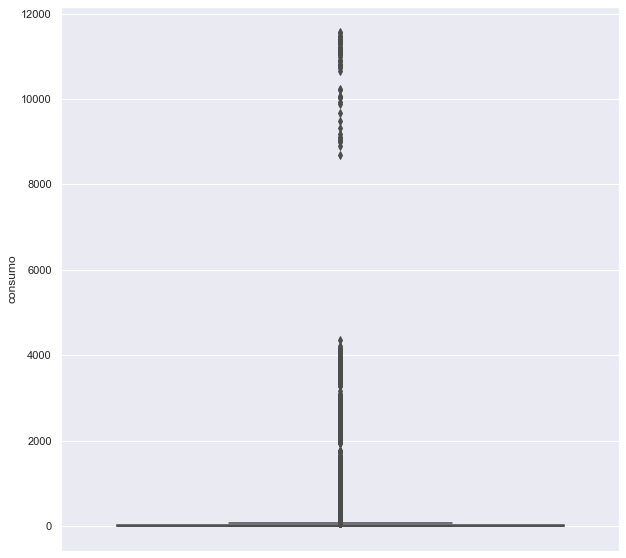

In [54]:
plt.figure(figsize = (10,10))
sns.boxplot(y = consumo.consumo, data = consumo)

In [55]:
def detect_outliers(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    ric = Q3 - Q1
    li = Q1 - (1.5 * ric)
    ls = Q3 + (1.5 * ric)
    return li, ls

In [57]:
consumo_out = consumo.copy()

In [58]:
li, ls = detect_outliers(consumo_out.consumo)

In [63]:
np.where(consumo.consumo > ls, ls, consumo.consumo).size

31691

In [59]:
consumo_out.consumo = np.where(consumo_out.consumo > ls, ls, consumo_out.consumo)
consumo_out.consumo = np.where(consumo_out.consumo < li, li, consumo_out.consumo)

In [60]:
consumo_out.describe()

,consumo
count,31691.000000
mean,22.470722
std,28.564674
min,0.000000
25%,1.960000
50%,7.550000
75%,33.670000
max,81.235000


<AxesSubplot:ylabel='consumo'>

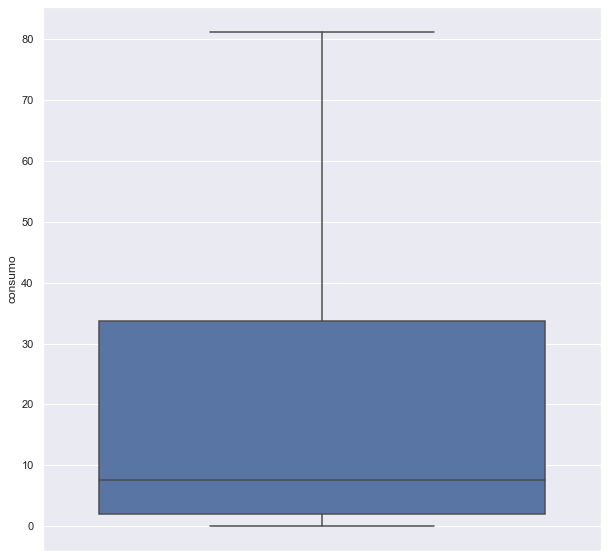

In [42]:
plt.figure(figsize = (10,10))
sns.boxplot(y = consumo.consumo, data = consumo)

In [68]:
def statistic_analytics(lista):
  m = statistics.mean(lista)
  m0 = statistics.mode(lista)
  md = statistics.median(lista)

  # Coeficiente de variação (CV)
  cv = (statistics.stdev(lista) / m)*100

  # Assimetria
  assimetria = stats.skew(lista)

  # Curtose
  curtose = stats.kurtosis(lista)

  print("CV = {:.2f}% , Assimetria = {:.2f}, Curtose = {:.2f}".format(cv, assimetria, curtose))

In [69]:
statistic_analytics(consumo_out.consumo)

CV = 127.12% , Assimetria = 1.22, Curtose = -0.09


<AxesSubplot:xlabel='consumo', ylabel='Density'>

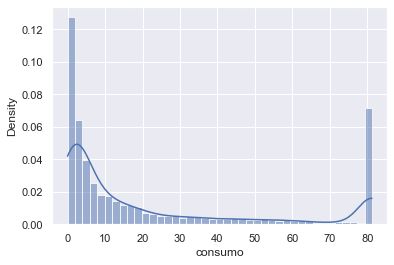

In [70]:
sns.histplot(data=consumo_out.consumo, stat="density", kde=True)

In [72]:
consumo_out.values

array([[datetime.date(2018, 1, 1), 'Autoprodutor', 'ALIMENTÍCIOS', ...,
        'PE\xa0', 0.01, '0'],
       [datetime.date(2018, 1, 1), 'Autoprodutor', 'ALIMENTÍCIOS', ...,
        'MG', 0.0, '0'],
       [datetime.date(2018, 1, 1), 'Autoprodutor', 'ALIMENTÍCIOS', ...,
        'MT', 0.68, '0'],
       ...,
       [datetime.date(2018, 1, 27), 'ConsumidorEspecial',
        'MANUFATURADOSDIVERSOS', ..., 'RJ', 26.91, '0'],
       [datetime.date(2018, 1, 27), 'ConsumidorEspecial',
        'MANUFATURADOSDIVERSOS', ..., 'MG', 65.54, '0'],
       [datetime.date(2018, 1, 27), 'ConsumidorEspecial',
        'MANUFATURADOSDIVERSOS', ..., 'MS', 5.26, '0']], dtype=object)

In [158]:
freq_classe_ramo = consumo_out.groupby(['classe', 'ramo']).size().unstack(1)
freq_classe_ramo

ramo,ACR,ALIMENTÍCIOS,BEBIDAS,COMÉRCIO,EXTRAÇÃODEMINERAISMETÁLICOS,MADEIRAPAPELECELULOSE,MANUFATURADOSDIVERSOS,METALURGIAEPRODUTOSDEMETAL,MINERAISNÃO-METÁLICOS,QUÍMICOS,SANEAMENTO,SERVIÇOS,TELECOMUNICAÇÕES,TRANSPORTE,TÊXTEIS,VEÍCULOS
classe,,,,,,,,,,,,,,,,
Autoprodutor,0,290,0,174,232,290,58,348,1044,406,0,174,0,0,232,0
ComercializadorVarejista,0,174,0,58,0,0,143,0,27,0,0,348,0,0,58,0
ConsumidorEspecial,0,1392,1276,1450,406,928,1269,855,1083,1052,570,1425,1368,368,855,627
ConsumidorLivre,0,1140,855,399,513,741,912,912,1311,798,285,1311,114,399,741,684
Distribuidor,1482,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Exportador,0,0,0,0,0,0,0,0,0,0,0,114,0,0,0,0


In [193]:
colunas = consumo_out.columns[1:5]
dict_col = {}
count = 0

for i in colunas:
    for j in colunas:
        if i == j:
            pass
        else:
            dict_col[count] = [i, j]
            count = count + 1

In [219]:
dict_col

{0: ['classe', 'ramo'],
 1: ['classe', 'submercado'],
 2: ['classe', 'uf'],
 3: ['ramo', 'classe'],
 4: ['ramo', 'submercado'],
 5: ['ramo', 'uf'],
 6: ['submercado', 'classe'],
 7: ['submercado', 'ramo'],
 8: ['submercado', 'uf'],
 9: ['uf', 'classe'],
 10: ['uf', 'ramo'],
 11: ['uf', 'submercado']}

In [227]:
df0 = consumo_out.groupby(dict_col[0]).size().unstack(1)
df1 = consumo_out.groupby(dict_col[1]).size().unstack(1)
df2 = consumo_out.groupby(dict_col[2]).size().unstack(1)
df3 = consumo_out.groupby(dict_col[3]).size().unstack(1)
df4 = consumo_out.groupby(dict_col[4]).size().unstack(1)
df5 = consumo_out.groupby(dict_col[5]).size().unstack(1)
df6 = consumo_out.groupby(dict_col[6]).size().unstack(1)
df7 = consumo_out.groupby(dict_col[7]).size().unstack(1)
df8 = consumo_out.groupby(dict_col[8]).size().unstack(1)
df9 = consumo_out.groupby(dict_col[9]).size().unstack(1)
df10 = consumo_out.groupby(dict_col[10]).size().unstack(1)
df11 = consumo_out.groupby(dict_col[11]).size().unstack(1)


<AxesSubplot:xlabel='ramo', ylabel='classe'>

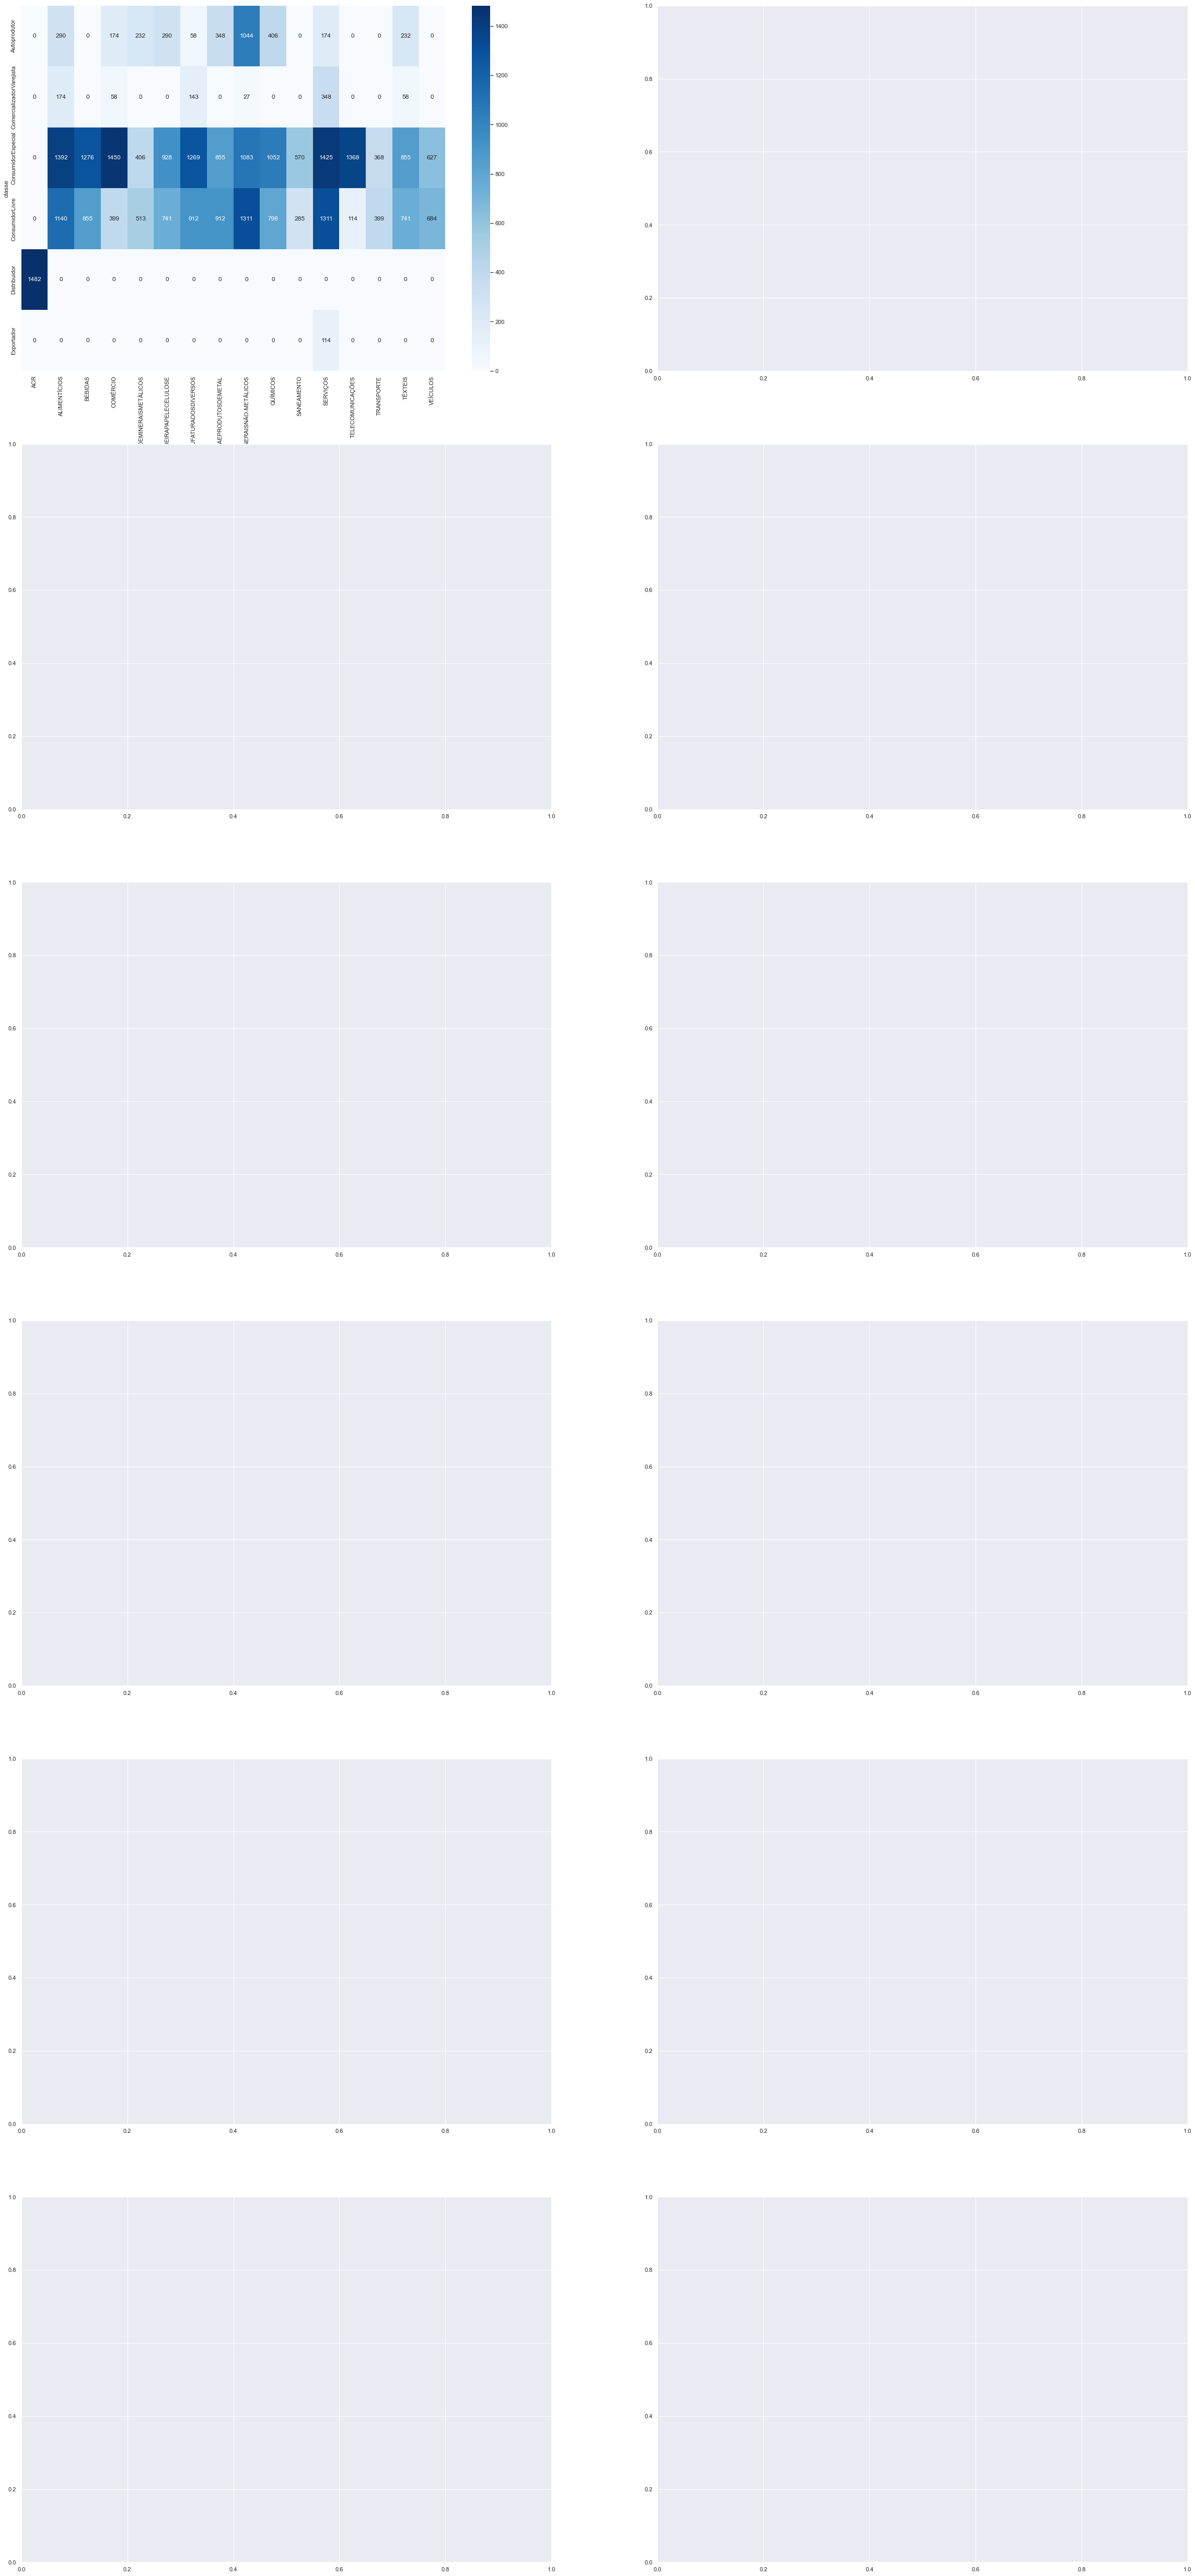

In [226]:
f, axes = plt.subplots(6,2, figsize = (40,90))
sns.heatmap(df0, annot=True, fmt="d", ax = axes[0,0], cmap="Blues")
sns.heatmap(df1, annot=True, fmt="d", ax = axes[0,1], cmap="Blues")
sns.heatmap(df2, annot=True, fmt="d", ax = axes[1,0], cmap="Blues")
sns.heatmap(df3, annot=True, fmt="d", ax = axes[1,1], cmap="Blues")
sns.heatmap(df4, annot=True, fmt="d", ax = axes[2,0], cmap="Blues")
sns.heatmap(df5, annot=True, fmt="d", ax = axes[2,1], cmap="Blues")
sns.heatmap(df6, annot=True, fmt="d", ax = axes[3,0], cmap="Blues")
sns.heatmap(df7, annot=True, fmt="d", ax = axes[3,1], cmap="Blues")
sns.heatmap(df8, annot=True, fmt="d", ax = axes[4,0], cmap="Blues")
sns.heatmap(df9, annot=True, fmt="d", ax = axes[4,1], cmap="Blues")
sns.heatmap(df10, annot=True, fmt="d", ax = axes[5,0], cmap="Blues")
sns.heatmap(df11, annot=True, fmt="d", ax = axes[5,1], cmap="Blues")

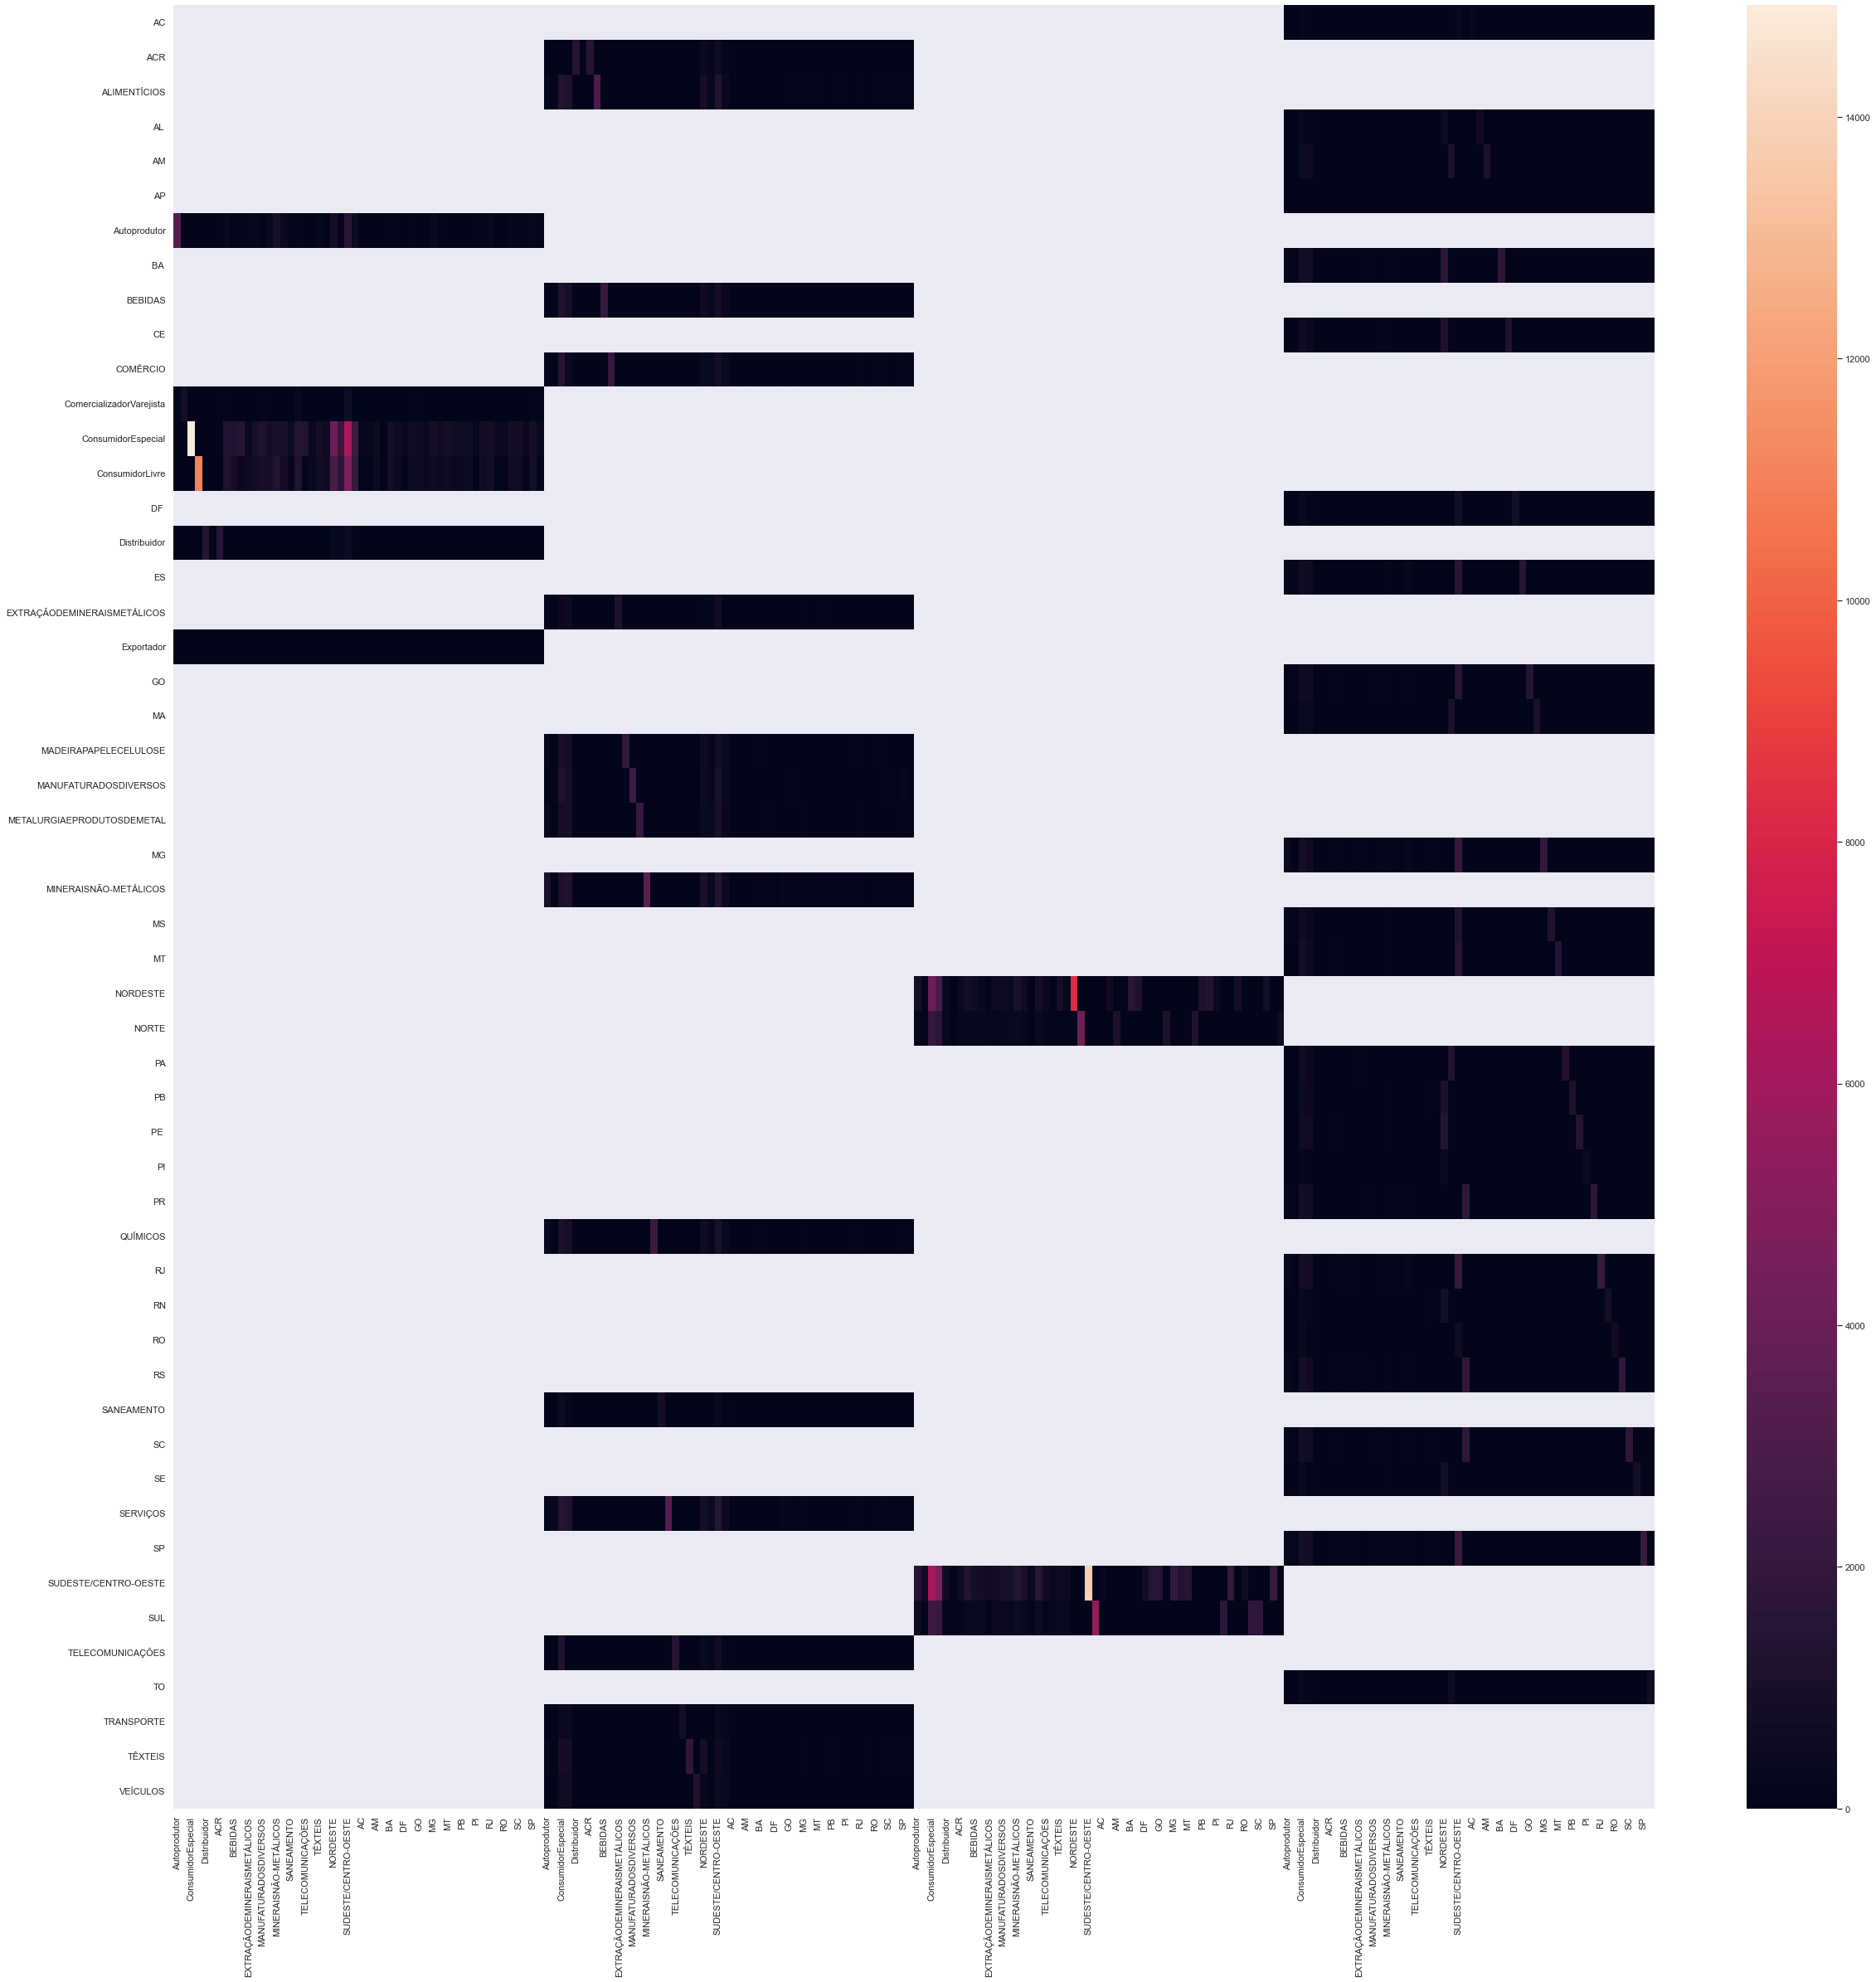

In [173]:
plt.figure(figsize = (40,40))
ax = sns.heatmap(df1)

In [74]:
consumo_out.columns

Index(['data', 'classe', 'ramo', 'submercado', 'uf', 'consumo', 'covid'], dtype='object')

In [128]:
consumo_quali = consumo_out.copy()

In [130]:
def dict_categories(df, var):
    categories = df[var].unique()
    dict_category = {}
    count = 0

    for i in categories:
        dict_category[i] = count
        count =+ 1

    return dict_category


In [131]:
dict_classes = dict_categories(consumo_quali, 'classe')
dict_ramo = dict_categories(consumo_quali, 'ramo')
dict_submercado = dict_categories(consumo_quali, 'submercado')
dict_uf = dict_categories(consumo_quali, 'uf')

In [132]:
consumo_quali['classe'] = consumo_quali.classe.map(dict_classes)
consumo_quali['ramo'] = consumo_quali.ramo.map(dict_ramo)
consumo_quali['submercado'] = consumo_quali.submercado.map(dict_submercado)
consumo_quali['uf'] = consumo_quali.uf.map(dict_uf)


In [144]:
def teste_qui_quadrado(X, y):
    chi_scores = chi2(X, y)

    scores = pd.Series(chi_scores[0], index=X.columns)
    pvalues = pd.Series(chi_scores[1], index=X.columns)

    data = pd.DataFrame({'Chi2':scores, 'p-Value':pvalues})

    return data

In [140]:
X = consumo_quali.loc[:, "classe":"uf"]
y = consumo_quali.classe

In [146]:
data_por_classe = teste_qui_quadrado(X,y)

data_por_classe

,Chi2,p-Value
classe,3248.000000,0.000000
ramo,0.110251,0.739858
submercado,0.447530,0.503510
uf,0.340052,0.559799


In [147]:
y = consumo_quali.ramo

data_por_ramo = teste_qui_quadrado(X,y)

data_por_ramo

,Chi2,p-Value
classe,0.119525,0.729551
ramo,2996.000000,0.000000
submercado,0.428320,0.512814
uf,0.546446,0.459773


In [148]:
y = consumo_quali.submercado

data_por_submercado = teste_qui_quadrado(X,y)

data_por_submercado

,Chi2,p-Value
classe,0.176705,6.742203e-01
ramo,0.155999,6.928672e-01
submercado,8226.000000,0.000000e+00
uf,193.314005,6.011563e-44


In [149]:
y = consumo_quali.uf

data_por_uf = teste_qui_quadrado(X,y)

data_por_uf

,Chi2,p-Value
classe,0.771291,3.798179e-01
ramo,1.143263,2.849639e-01
submercado,1110.475561,1.746189e-243
uf,1432.000000,0.000000e+00


In [88]:
from sklearn.feature_selection import chi2

df = consumo_out.iloc[:, 2:]

resultant = pd.DataFrame(data=[(0 for i in range(len(df.columns))) for i in range(len(df.columns))], 
                         columns=list(df.columns))
resultant.set_index(pd.Index(list(df.columns)), inplace = True)

for i in list(df.columns):
    for j in list(df.columns):
        if i != j:
            chi2_val, p_val = chi2(np.array(df[i]).reshape(-1, 1), np.array(df[j]).reshape(-1, 1))
            print(chi2_val, p_val)
            resultant.loc[i,j] = p_val
print(resultant)

In [ ]:
# Plotting a heatmap
fig = plt.figure(figsize=(6,6))
sns.heatmap(resultant, annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.show()